In [1]:
# Uncomment the following to install Python denpendencies
# ! pip install -r https://raw.githubusercontent.com/esciencecenter-digital-skills/2024-04-15-geospatial-python-EGU/main/requirements.txt

In [2]:
import geopandas as gpd
import osmnx as ox

import pystac_client
import odc.stac

import xarray as xr
import rioxarray
import xrspatial 

import matplotlib.pyplot as plt

In [3]:
# Get polygon of Rhodes
rhodes = ox.geocode_to_gdf("Rhodes")

# Inspect the Geodataframe
rhodes

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((27.68357 36.15271, 27.68378 36...",36.458283,35.876662,28.247628,27.683572,370997710,relation,452614,36.17253,27.919402,place,island,17,0.60392,island,Rhodes,"Rhodes, Aegean, Greece"


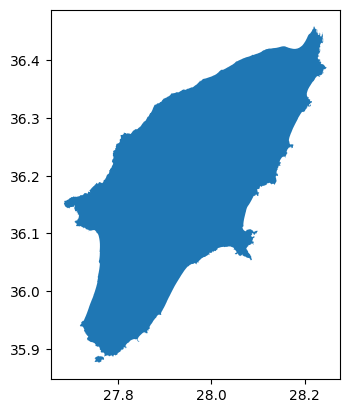

In [4]:
# Visualize the polygon
rhodes.plot()

# Save the polygon to a GeoPackage file
rhodes.to_file("rhodes.gpkg")

In [5]:
# Setup search client from a URL
api_url = 'https://earth-search.aws.element84.com/v1'
client = pystac_client.Client.open(api_url)

# Setup collection
# One can check the available collections by walking through the collections:
# [collection for collection in client.get_collections()]
collection = 'sentinel-2-l2a'  # Sentinel-2, Level 2A

# Get the search geometry from the GeoDataFrame
# We select the "geometry" column and the first row (there is only one row)
polygon = rhodes['geometry'].iloc[0]

# Construct the search
search = client.search(
    collections=[collection],
    intersects=polygon,
    datetime='2023-07-01/2023-08-31', # date range for the search
    query=['eo:cloud_cover<10'] # cloud cover less than 1%
)

# inspect the search results
items = search.item_collection()
len(items) # Inspect how many items are found

# Save search results
items.save_object('rhodes_sentinel-2.json')

In [6]:
# bands of interest
bands = ["red", "green", "blue", "nir", "scl"]

# Load the search results as xarray.Dataset
# This load will be lazy, so the data is not yet loaded into memory 
ds = odc.stac.load(
    items,
    groupby="solar_day", # group the image with the same solar day
    bands=bands,
    resolution=40, # loading resolution
    chunks={"x": 2048, "y": 2048}, # specify the chunk size for Dask
    bbox=polygon.bounds,
    dtype="uint16"
)

# Inspect the loaded dataset
ds

<xarray.Dataset> Size: 522MB
Dimensions:      (y: 1626, x: 1285, time: 25)
Coordinates:
  * y            (y) float64 13kB 4.036e+06 4.035e+06 ... 3.971e+06 3.97e+06
  * x            (x) float64 10kB 5.613e+05 5.613e+05 ... 6.126e+05 6.126e+05
    spatial_ref  int32 4B 32635
  * time         (time) datetime64[ns] 200B 2023-07-01T09:10:15.805000 ... 20...
Data variables:
    red          (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    green        (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    blue         (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    nir          (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    scl          (time, y, x) uint16 104MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>

/Users/fnattino/Training/Workshops/2024-04-15-geospatial-python-EGU/venv/lib/python3.9/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


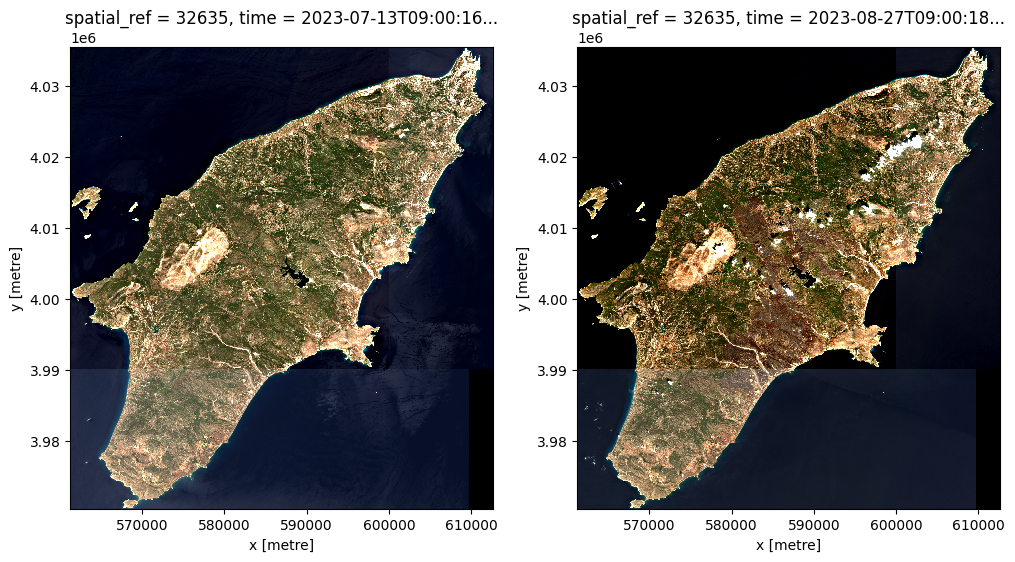

In [7]:
# Visualize the true color image before and after the wild fire
ds_before = ds.sel(time="2023-07-13", method="nearest")
ds_after = ds.sel(time="2023-08-27", method="nearest")

# Define a function to create a true color image
def rgb_img(ds):
    ds_rgb = ds[["red", "green", "blue"]].to_array()

    # Sentiel-2 L2A data provides Bottom of Atmosphere (BOA) reflectance times 10,000
    # In some cases, the reflectance values are larger than 10000 for some bright relections
    # For simplicity, we set all values larger than 10000 to 10000
    # Then we scale the reflectance to 0-255
    ds_rgb = ds_rgb.clip(max=10000)
    img = ds_rgb / 10_000
    return img
    
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
rgb_img(ds_before).plot.imshow(ax=axs[0], robust=True) # Use robust=True to improve contrast
rgb_img(ds_after).plot.imshow(ax=axs[1], robust=True)

In [8]:
def mask_water_and_clouds(ds):
    """
    https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm-overview
    """
    mask = ds["scl"].isin([3, 6, 8, 9, 10])
    return ds.where(~mask)

ds_masked = mask_water_and_clouds(ds)
ds_masked

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 25, y: 1626, x: 1285)
Coordinates:
  * y            (y) float64 13kB 4.036e+06 4.035e+06 ... 3.971e+06 3.97e+06
  * x            (x) float64 10kB 5.613e+05 5.613e+05 ... 6.126e+05 6.126e+05
    spatial_ref  int32 4B 32635
  * time         (time) datetime64[ns] 200B 2023-07-01T09:10:15.805000 ... 20...
Data variables:
    red          (time, y, x) float32 209MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    green        (time, y, x) float32 209MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    blue         (time, y, x) float32 209MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    nir          (time, y, x) float32 209MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>
    scl          (time, y, x) float32 209MB dask.array<chunksize=(1, 1626, 1285), meta=np.ndarray>

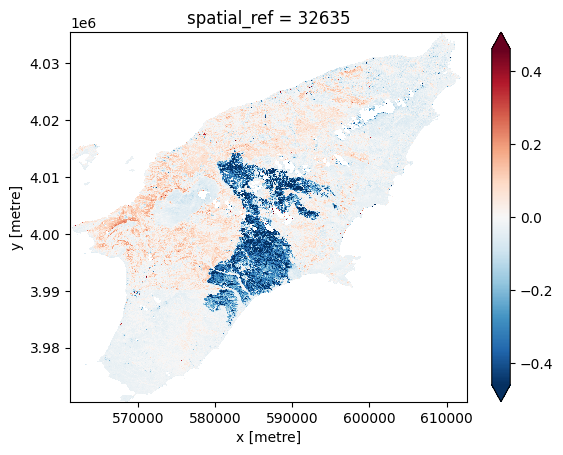

/Users/fnattino/Training/Workshops/2024-04-15-geospatial-python-EGU/venv/lib/python3.9/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [9]:
# Calculate the NDVI
ndvi = (ds_masked["nir"] - ds_masked["red"]) / (ds_masked["nir"] + ds_masked["red"])

# Calculate the difference of NDVI before and after the fires
ndvi_before = ndvi.sel(time="2023-07-13", method="nearest")
ndvi_after = ndvi.sel(time="2023-08-27", method="nearest")
ndvi_diff = ndvi_after - ndvi_before

# Visualize the NDVI difference
ndvi_diff.plot.imshow(robust=True)

In [10]:
# If NDVI drops more than 0.6, consider it as a vegetation damage
# Note this is not a scientific threshold, since cloud coverage can also cause NDVI change
# For simplicity, we use this threshold to demonstrate the process
# We will create a burned index map and mark the burned area with 1
burned_mask = ndvi_diff < -0.6

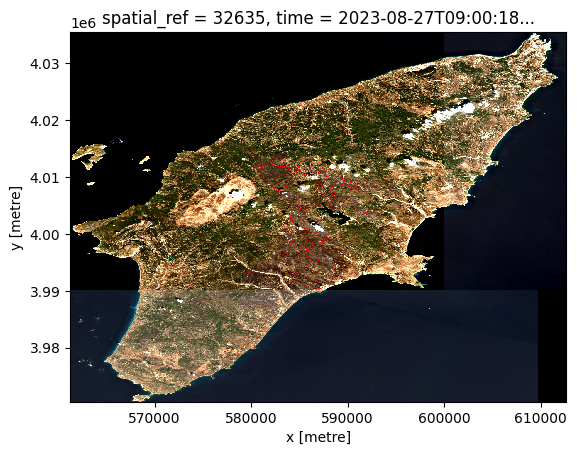

/Users/fnattino/Training/Workshops/2024-04-15-geospatial-python-EGU/venv/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [11]:
# Then visualize the burned index map over the true color image after the wild fire
rgb = rgb_img(ds_after)  # Build a true color image
rgb[0, :, :] = xr.where(burned_mask, 1, rgb[0, :, :]) # Mark the burned area with red
rgb[1:3, :, :] = xr.where(burned_mask, 0, rgb[1:3, :, :]) # Exclude the green and blue channel at burned location
rgb.plot.imshow(robust=True)  

In [12]:
# get highways
highways = ox.features_from_place(
    "Rhodes",
    tags={
        "highway":[
            "primary", 
            "secondary", 
            "tertiary",
        ]
    }
)

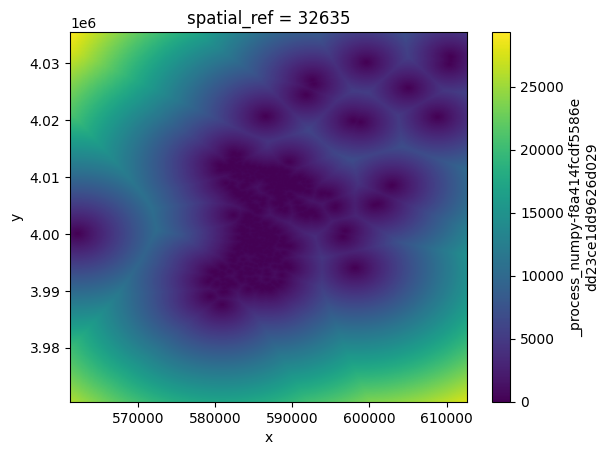

In [13]:
distance = xrspatial.proximity(burned_mask)
distance.plot.imshow()

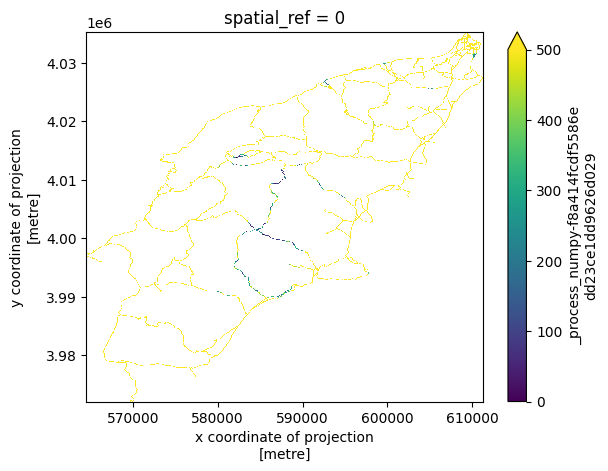

In [14]:
highways_reprojected = highways.to_crs(burned_mask.rio.crs)

distance_clip = distance.rio.clip(
    highways_reprojected.buffer(50)
)

distance_clip.plot.imshow(vmax=500)  # visualize roads closer than 500 meters from fires